函式庫導入完成。

1. 原始資料載入成功，共 5016 筆。

--- 開始進行資料處理與特徵工程 ---
2. 移除非資料行後，剩餘 5016 筆。
3. 經過所有條件篩選後，最終用於建模的乾淨資料共 5010 筆。
4. 特徵工程完成。
最終用於建模的 DataFrame 預覽：
   Hour  DayOfWeek  Month  IsWeekend  IsRushHour  StartExit_Exit_1  \
0     4          6      1          1           0                 0   
1     5          6      1          1           0                 0   
2     8          6      1          1           1                 0   
3    12          6      1          1           0                 0   
4    12          6      1          1           0                 0   

   StartExit_Exit_2  TotalSeconds  
0                 1           967  
1                 1          1282  
2                 1           579  
3                 1           726  
4                 1           659  

--- 開始訓練模型 ---
訓練集大小: 4008 筆, 測試集大小: 1002 筆。
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

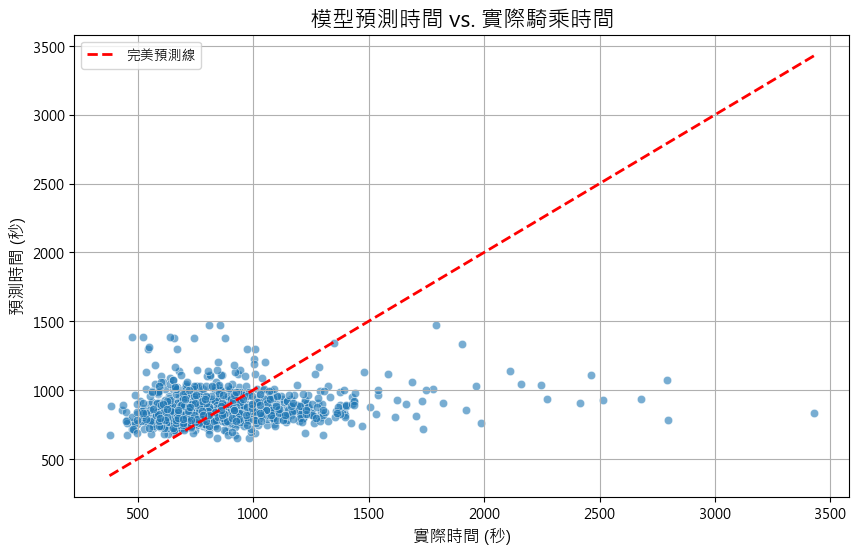


--- 特徵重要性分析 ---


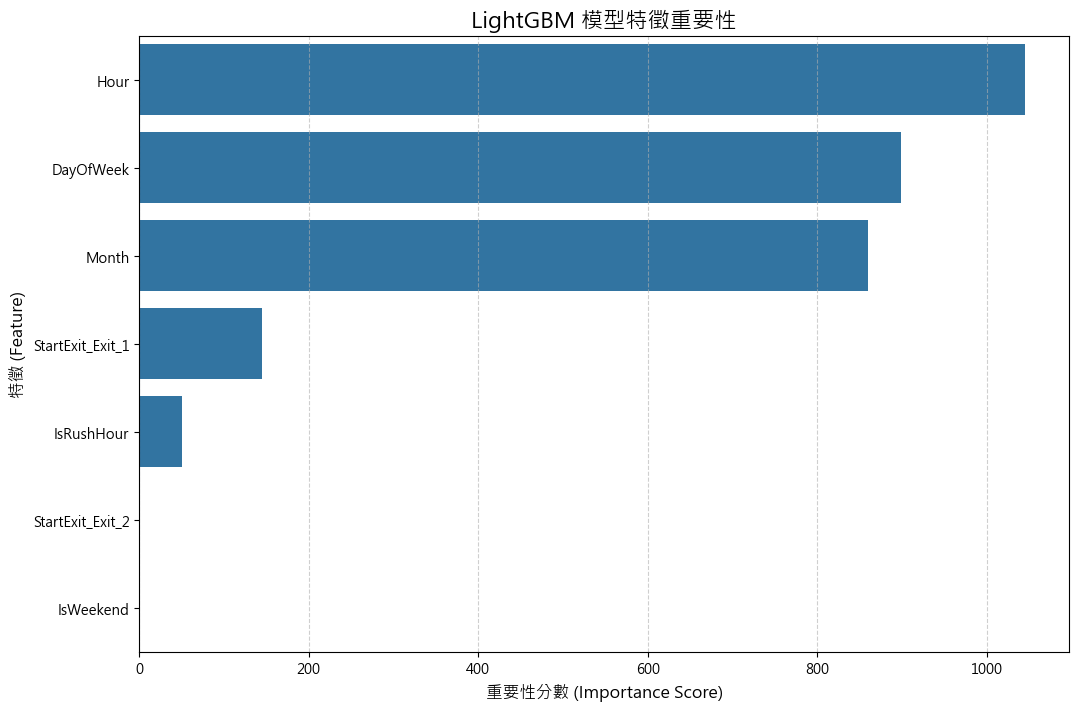


程式執行完畢。


In [1]:
# =============================================================================
# 步驟 0：導入必要的函式庫
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
print("函式庫導入完成。\n")


# =============================================================================
# 步驟 1：資料載入與視覺化設定
# =============================================================================
try:
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows
except:
    try:
        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # Mac
    except:
        print("警告：未找到指定的中文字體，圖表標題可能顯示為亂碼。")
plt.rcParams['axes.unicode_minus'] = False

file_path = u'2023資料剖析後內容1~8月芝山到天母0609整理二版.csv' 
try:
    df_raw = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df_raw = pd.read_csv(file_path, encoding='big5')
except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{file_path}'。請確認檔案名稱和路徑是否正確。")
    exit()

print(f"1. 原始資料載入成功，共 {len(df_raw)} 筆。")


# =============================================================================
# 步驟 2 & 3：資料清理、預處理與特徵工程 (已修正核心問題)
# =============================================================================
print("\n--- 開始進行資料處理與特徵工程 ---")

df = df_raw.copy()
df.dropna(subset=['Date'], inplace=True)
print(f"2. 移除非資料行後，剩餘 {len(df)} 筆。")

# --- 【核心修正】修正 Time2 的解析函數 ---
def parse_mm_ss_to_seconds(time_str):
    """
    專門解析 MM:SS 或 HH:MM:SS 格式的字串轉為總秒數。
    """
    try:
        time_str = str(time_str).strip()
        parts = list(map(int, time_str.split(':')))
        
        if len(parts) == 2:  # 格式為 MM:SS
            minutes, seconds = parts
            return minutes * 60 + seconds
        elif len(parts) == 3: # 格式為 HH:MM:SS
            hours, minutes, seconds = parts
            return hours * 3600 + minutes * 60 + seconds
        else:
            return np.nan # 格式不符
    except (ValueError, TypeError):
        return np.nan

df['TotalSeconds'] = df['Time2'].apply(parse_mm_ss_to_seconds)

df['Date_str'] = df['Date'].astype(int).astype(str)
df['Time1_str'] = df['Time1'].astype(str).str.strip()
df['Datetime'] = pd.to_datetime(df['Date_str'] + ' ' + df['Time1_str'], format='%Y%m%d %H:%M:%S', errors='coerce')

df_clean = df[
    (df['TotalSeconds'].notna()) &
    (df['Datetime'].notna()) &
    (df['TotalSeconds'] >= 180) & 
    (df['TotalSeconds'] <= 3600)
].copy() 

print(f"3. 經過所有條件篩選後，最終用於建模的乾淨資料共 {len(df_clean)} 筆。")

if len(df_clean) == 0:
    print("\n錯誤：所有資料都在清理過程中被移除了。即使修正解析邏輯後依然失敗，請仔細檢查資料。")
    exit()

# --- 特徵工程 ---
df_clean['TotalSeconds'] = df_clean['TotalSeconds'].astype(int)

df_clean['Hour'] = df_clean['Datetime'].dt.hour
df_clean['DayOfWeek'] = df_clean['Datetime'].dt.dayofweek
df_clean['Month'] = df_clean['Datetime'].dt.month
df_clean['IsWeekend'] = df_clean['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df_clean['IsRushHour'] = df_clean['Hour'].apply(lambda h: 1 if (7 <= h <= 9) or (17 <= h <= 19) else 0)

def normalize_exit(stp_name):
    return 'Exit_1' if '1號' in str(stp_name) else 'Exit_2'
df_clean['StartExit'] = df_clean['Stp1'].apply(normalize_exit)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int64)
encoded_features = ohe.fit_transform(df_clean[['StartExit']])
new_feature_names = ohe.get_feature_names_out(['StartExit'])
encoded_df = pd.DataFrame(encoded_features, columns=new_feature_names, index=df_clean.index)
df_final = pd.concat([df_clean, encoded_df], axis=1)

target = 'TotalSeconds'
features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsRushHour'] + list(new_feature_names)
df_model = df_final[features + [target]].reset_index(drop=True)

print("4. 特徵工程完成。")
print("最終用於建模的 DataFrame 預覽：")
print(df_model.head())

# =============================================================================
# 步驟 4：模型訓練 (Model Training)
# =============================================================================
print("\n--- 開始訓練模型 ---")

X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"訓練集大小: {X_train.shape[0]} 筆, 測試集大小: {X_test.shape[0]} 筆。")

lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
print("模型訓練完成！")


# =============================================================================
# 步驟 5：模型評估與視覺化 (Model Evaluation & Visualization)
# =============================================================================
print("\n--- 模型評估結果 ---")
y_pred = lgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"平均絕對誤差 (MAE): {mae:.2f} 秒 (約 {mae/60:.2f} 分鐘)")
print(f"R-squared (R²): {r2:.2f}")

# --- 繪製「預測值 vs. 實際值」散點圖 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label='完美預測線')
plt.title('模型預測時間 vs. 實際騎乘時間', fontsize=16)
plt.xlabel('實際時間 (秒)', fontsize=12)
plt.ylabel('預測時間 (秒)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 繪製特徵重要性圖 ---
print("\n--- 特徵重要性分析 ---")
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM 模型特徵重要性', fontsize=16)
plt.xlabel('重要性分數 (Importance Score)', fontsize=12)
plt.ylabel('特徵 (Feature)', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\n程式執行完畢。")